In [1]:
!pip install git+https://github.com/openopt/copt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openopt/copt.git to /tmp/pip-req-build-96c5te93
  Running command git clone -q https://github.com/openopt/copt.git /tmp/pip-req-build-96c5te93
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for copt: filename=copt-0.9.0-py3-none-any.whl size=37601 sha256=f2ae792522144628aa0070532dc5da7142e3a0a598ce436b7c7b20e40da4bcbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pe877p4d/wheels/5a/2c/24/8c054b4fcfd93eec7d7b66ffe099ebc66fabbb9fe06f6bb982
Successfully built copt


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copt as cp
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from time import time

# .. datasets and their loading functions ..
import copt.constraint
import copt.loss
plt.style.use('seaborn')

In [3]:
c1 = 0.3

def armijo_step_size(x):
    inequality_satisfied = True
    step_size_t = 1
    f_grad = copt.utils.build_func_grad(x['jac'], x['fun'], x['args'], x['eps'])
    current_grad = f_grad(x['x'])[1]

    while inequality_satisfied:
      f_next, grad_next = f_grad(x['x'] - step_size_t * x['update_direction'])


      if f_grad(x['x'] + step_size_t * x['update_direction'])[0] <= x['f_t'] + step_size_t * c1 * current_grad.dot(x['update_direction']):
        break
      else:
        step_size_t = step_size_t/2
    return step_size_t

In [6]:
np.random.seed(0)


def callbackGrad(x, grads, step_sizes):
  step_sizes.append(x['step_size'])
  grads.append(x['grad'])
  return True

In [8]:
datasets = [
    ("Gisette", cp.datasets.load_gisette, 6e3),
    ("RCV1", cp.datasets.load_rcv1, 2e4),
    ("Madelon", cp.datasets.load_madelon, 20.0),
    ("Covtype", cp.datasets.load_covtype, 200.0),
]


variants_fw = [
    armijo_step_size,
    "backtracking",
    "DR",
    "sublinear",
]

dataset_grads = {}
dataset_steps = {}

for dataset_title, load_data, alpha in datasets:
    plt.figure()
    print("Running on the %s dataset" % dataset_title)

    X, y = load_data()
    n_samples, n_features = X.shape

    l1_ball = copt.constraint.L1Ball(alpha)
    f = copt.loss.LogLoss(X, y)
    x0 = np.zeros(n_features)
    step_dict_grads = {}
    step_dict_steps = {}
    grads = []

    for i, step in enumerate(tqdm(variants_fw)):
        grads=[]
        step_sizes = []
        if i == 0:
            sol = cp.minimize_frank_wolfe(
                f.f_grad, x0, l1_ball.lmo, callback=lambda x: callbackGrad(x, grads, step_sizes), step=step, lipschitz=f.lipschitz, max_iter=100
            )
            step_dict_grads['Armijo'] = grads
            step_dict_steps['Armijo'] = step_sizes
        else:
            sol = cp.minimize_frank_wolfe(
                f.f_grad, x0, l1_ball.lmo, callback=lambda x: callbackGrad(x, grads, step_sizes), step=step, lipschitz=f.lipschitz, max_iter=400
            )
            step_dict_grads[step] = grads
            step_dict_steps[step] = step_sizes
    dataset_grads[dataset_title] = step_dict_grads
    dataset_steps[dataset_title] = step_dict_steps

Running on the Gisette dataset


100%|██████████| 4/4 [05:20<00:00, 80.08s/it]


Running on the RCV1 dataset
rcv1 dataset is not present in the folder /root/copt_data/rcv1. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/rcv1/X_test.indptr.npy
Extracting data to /root/copt_data/rcv1/y_train.npy
Extracting data to /root/copt_data/rcv1/X_test.data.npy
Extracting data to /root/copt_data/rcv1/X_train.indptr.npy
Extracting data to /root/copt_data/rcv1/y_test.npy
Extracting data to /root/copt_data/rcv1/X_train.data.npy
Extracting data to /root/copt_data/rcv1/X_train.indices.npy
Extracting data to /root/copt_data/rcv1/X_test.indices.npy


100%|██████████| 4/4 [16:00<00:00, 240.07s/it]


Running on the Madelon dataset
madelon dataset is not present in the folder /root/copt_data/madelon. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/madelon/X_train.indptr.npy
Extracting data to /root/copt_data/madelon/X_test.indptr.npy
Extracting data to /root/copt_data/madelon/y_test.npy
Extracting data to /root/copt_data/madelon/y_train.npy
Extracting data to /root/copt_data/madelon/X_test.data.npy
Extracting data to /root/copt_data/madelon/X_train.indices.npy
Extracting data to /root/copt_data/madelon/X_train.data.npy
Extracting data to /root/copt_data/madelon/X_test.indices.npy


100%|██████████| 4/4 [00:19<00:00,  4.79s/it]


Running on the Covtype dataset
covtype dataset is not present in the folder /root/copt_data/covtype. Downloading it ...
Finished downloading
Extracting data to /root/copt_data/covtype/y_train.npy
Extracting data to /root/copt_data/covtype/X_train.indptr.npy
Extracting data to /root/copt_data/covtype/X_train.data.npy
Extracting data to /root/copt_data/covtype/X_train.indices.npy


100%|██████████| 4/4 [03:27<00:00, 51.82s/it]


<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

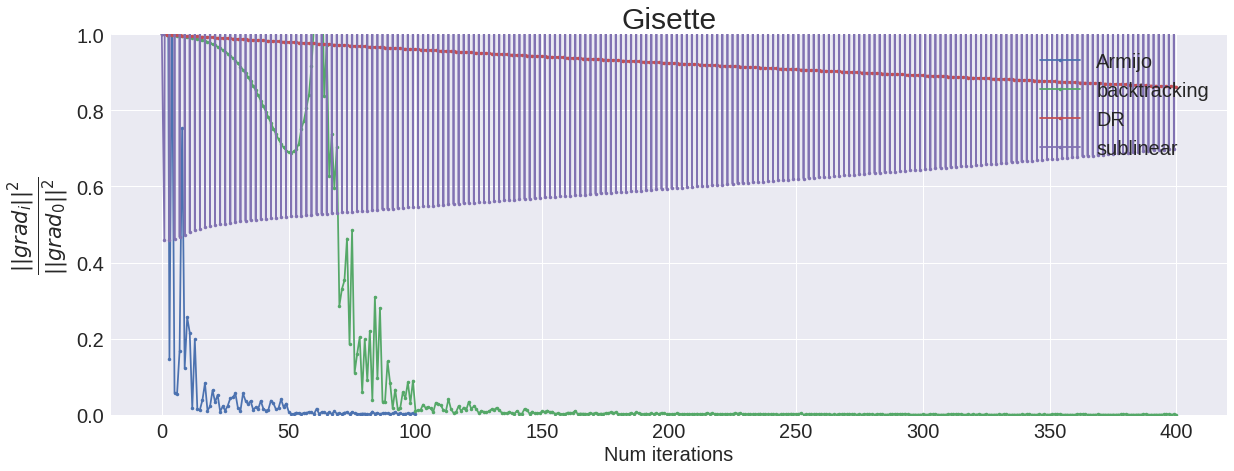

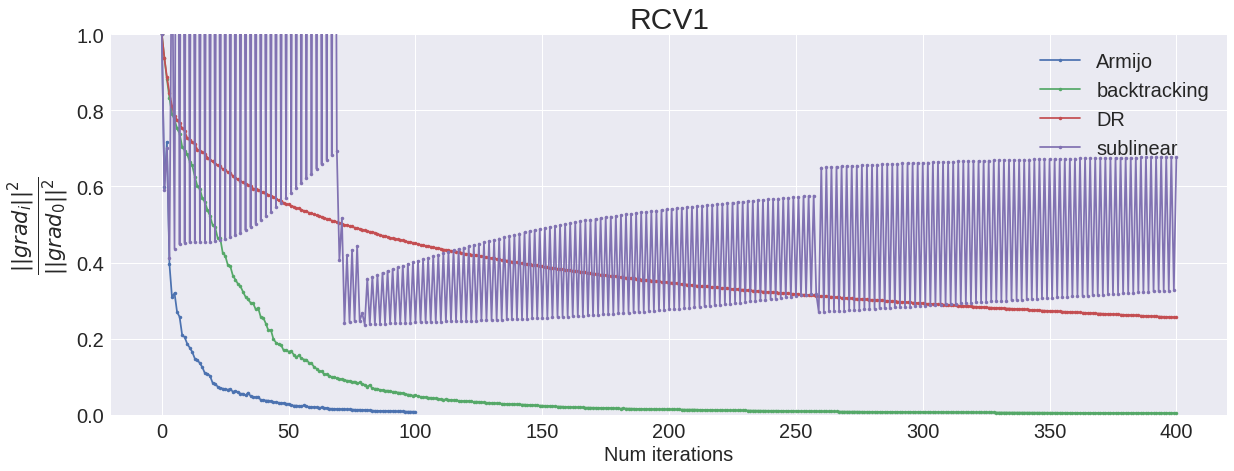

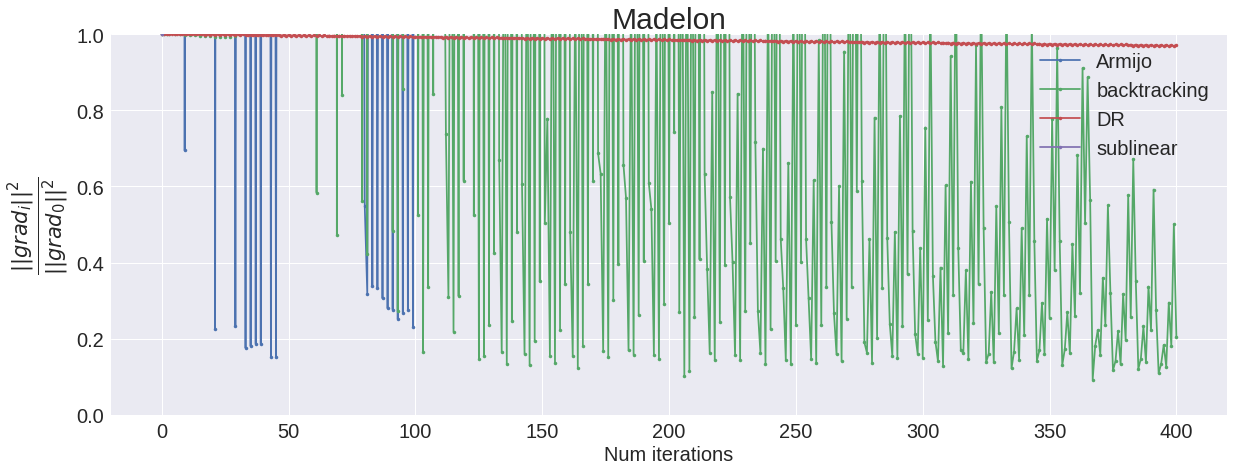

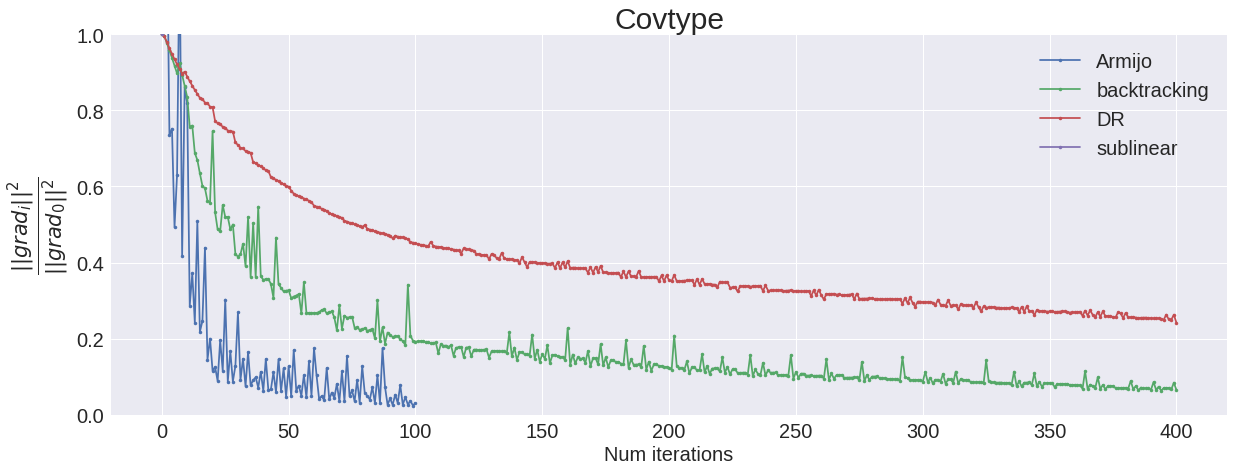

In [9]:
for dataset_title in dataset_grads.keys():
    plt.figure(figsize=(20,7))
    for step in dataset_grads[dataset_title]:
        grads = np.linalg.norm(np.array(dataset_grads[dataset_title][step]), axis=1) ** 2
        plt.plot(grads / grads[0], label = step, marker='.')

    plt.title(dataset_title, fontsize=30)
    plt.ylim(0, 1)
    plt.legend(fontsize=20, loc=1)
    plt.tick_params(labelsize=20)
    plt.xlabel('Num iterations', fontsize=20)
    plt.ylabel(r'$\frac{||grad_i||^2}{||grad_0||^2}$', fontsize=30)

    plt.savefig(dataset_title+'.png', bbox_inches='tight', pad_inches=0)
    plt.show()

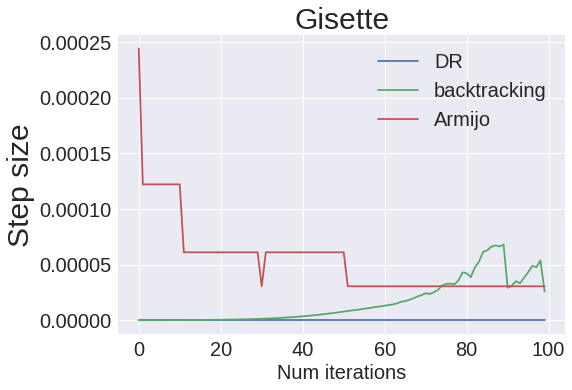

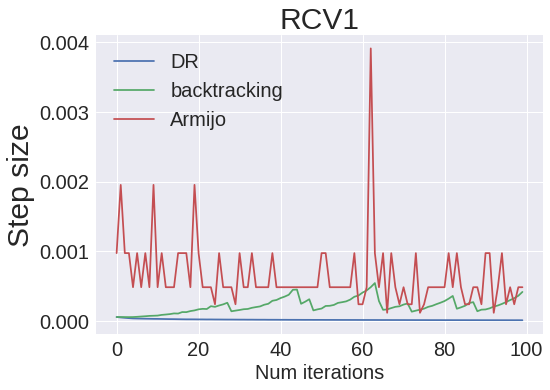

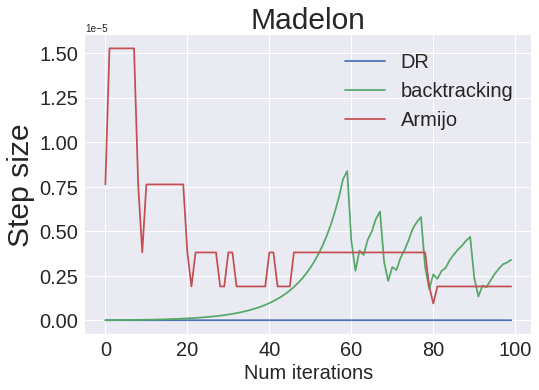

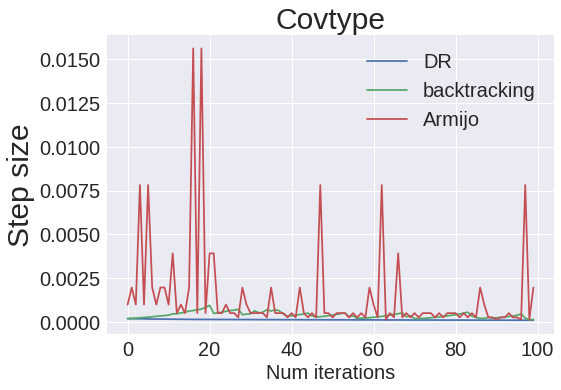

In [11]:
for dataset_title in dataset_steps.keys():
    plt.title(dataset_title, fontsize=30)
    plt.plot(dataset_steps[dataset_title]['DR'][:100], label='DR')
    plt.plot(dataset_steps[dataset_title]['backtracking'][:100], label='backtracking')
    plt.plot(dataset_steps[dataset_title]['Armijo'][:100], label='Armijo')
    plt.legend(fontsize=20)

    plt.tick_params(labelsize=20)
    plt.xlabel('Num iterations', fontsize=20)
    plt.ylabel('Step size', fontsize=30)
    plt.savefig(dataset_title+'_step.png', bbox_inches='tight', pad_inches=0)
    plt.show()

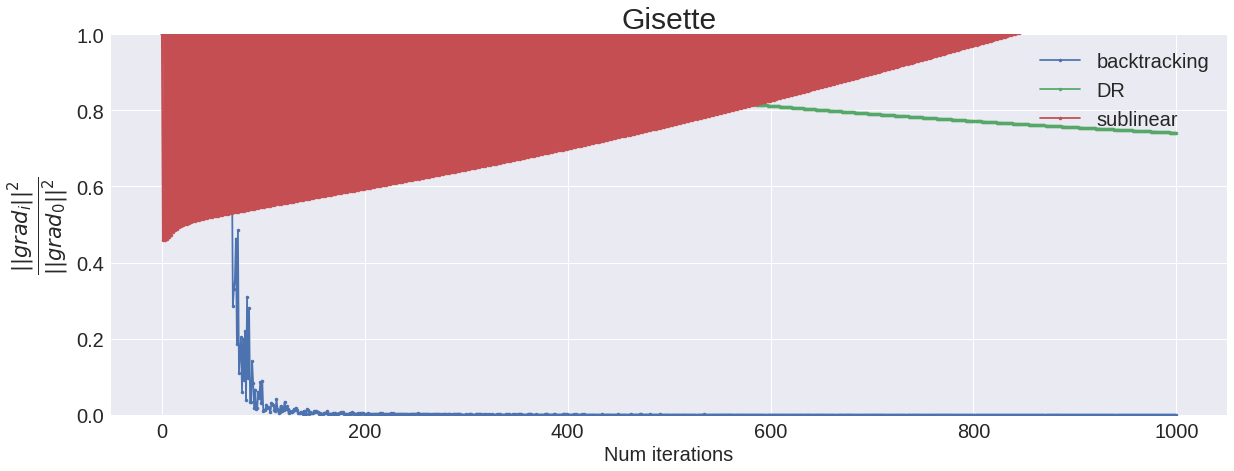

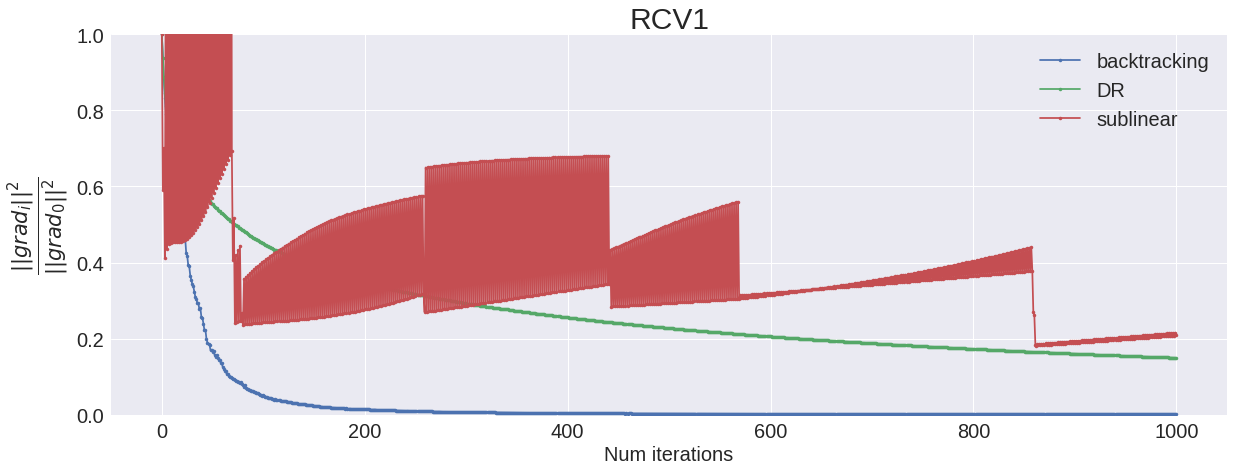

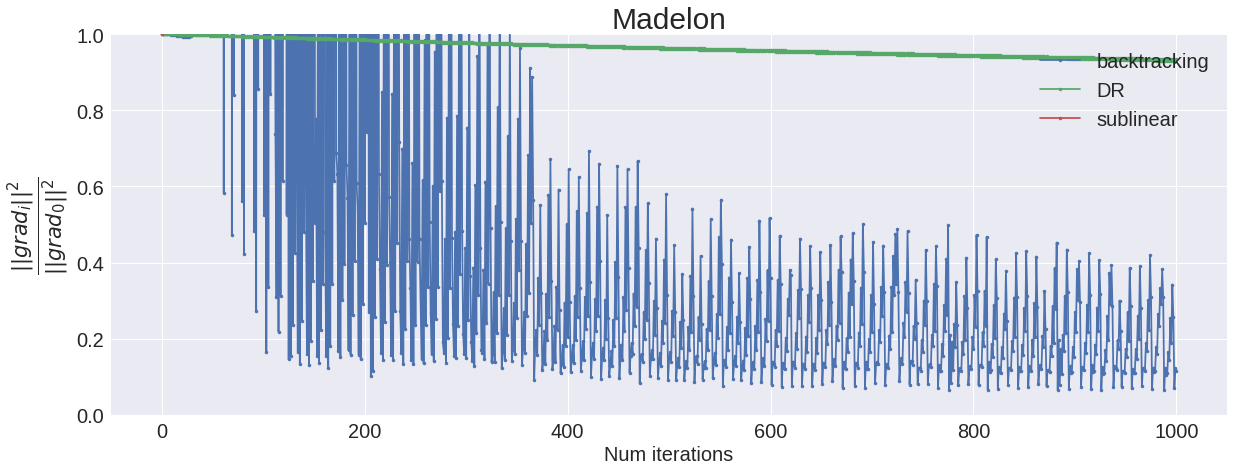

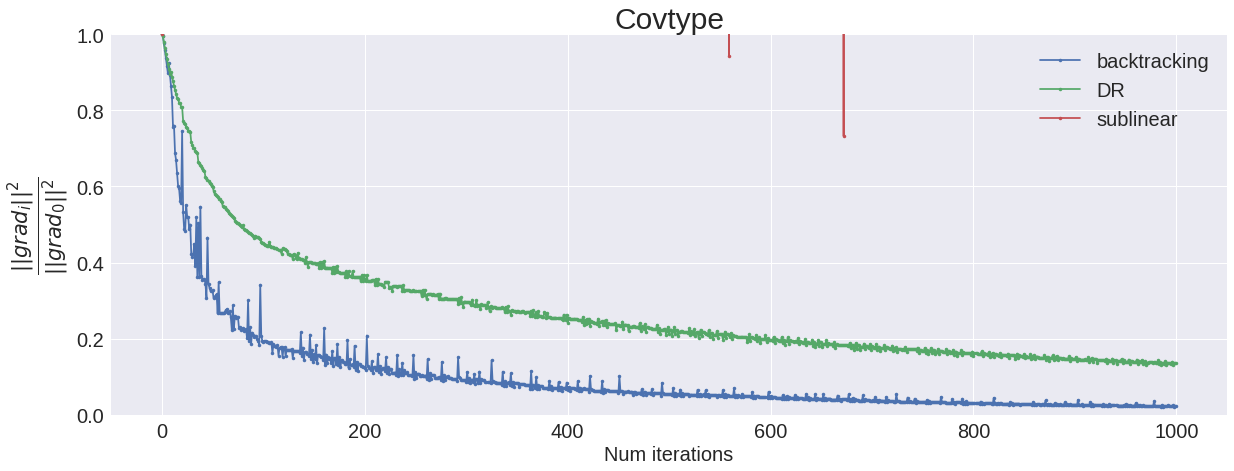

In [ ]:
for dataset_title in dataset_grads.keys():
    plt.figure(figsize=(20,7))
    for step in dataset_grads[dataset_title]:
        grads = np.linalg.norm(np.array(dataset_grads[dataset_title][step]), axis=1) ** 2
        plt.plot(grads / grads[0], label = step, marker='.')

    plt.title(dataset_title, fontsize=30)
    plt.ylim(0, 1)
    plt.legend(fontsize=20, loc=1)
    plt.tick_params(labelsize=20)
    plt.xlabel('Num iterations', fontsize=20)
    plt.ylabel(r'$\frac{||grad_i||^2}{||grad_0||^2}$', fontsize=30)

    plt.savefig(dataset_title+'.png')
    plt.show()

In [18]:
from sklearn.datasets import make_regression

def LASSO_FW(n, max_iter):
    n_samples, n_features = n, n
    A, b, coef = make_regression(n, n, coef=True)
    alpha = .5 * n_features

    X, y = A, b

    l1_ball = copt.constraint.L1Ball(alpha)
    f = copt.loss.SquareLoss(X, y)
    x0 = np.zeros(n_features)
    step_dict_grads = {}
    step_dict_steps = {}

    variants_fw = [
        "backtracking",
        "DR",
        "sublinear",
    ]
    for step in tqdm(variants_fw):
        grads=[]
        step_sizes = []
        sol = cp.minimize_frank_wolfe(
            f.f_grad, x0, l1_ball.lmo, callback=lambda x: callbackGrad(x, grads, step_sizes), step=step, lipschitz=f.lipschitz, max_iter=max_iter
        )
        step_dict_grads[step] = grads
        step_dict_steps[step] = step_sizes

    for step in variants_fw:
        grads = np.linalg.norm(np.array(step_dict_grads[step]), axis=1) ** 2
        plt.plot(grads / grads[0], label = step, marker='.')

    plt.title(f'Lasso regression, n={n}, '+r'$\alpha$=' + f'{round(alpha)}', fontsize=30)
    plt.ylim(0, 1)
    plt.legend(fontsize=20, loc=4)
    plt.tick_params(labelsize=20)
    plt.xlabel('Num iterations', fontsize=20)
    plt.ylabel(r'$\frac{||grad_i||^2}{||grad_0||^2}$', fontsize=30)

    # plt.savefig(f'Lasso_{n}'+'.png')
    plt.show()

    plt.title('Lasso regression, '+r'$\alpha$=' + f'{round(alpha)}', fontsize=30)
    plt.plot(step_dict_steps['DR'], label='DR')
    plt.plot(step_dict_steps['backtracking'], label='backtracking')
    plt.legend(fontsize=20)

    plt.tick_params(labelsize=20)
    plt.xlabel('Num iterations', fontsize=20)
    plt.ylabel('Step size', fontsize=30)
    # plt.savefig(f'Lasso_{n}'+'_step.png')
    plt.show()

100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


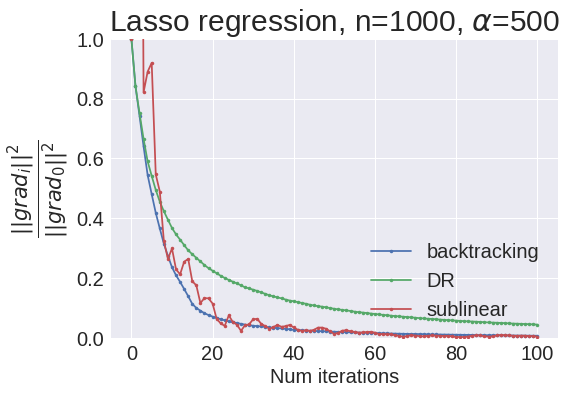

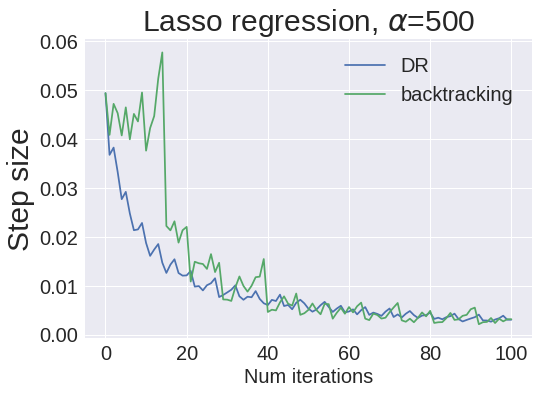

In [22]:
LASSO_FW(1000, max_iter=100)

100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


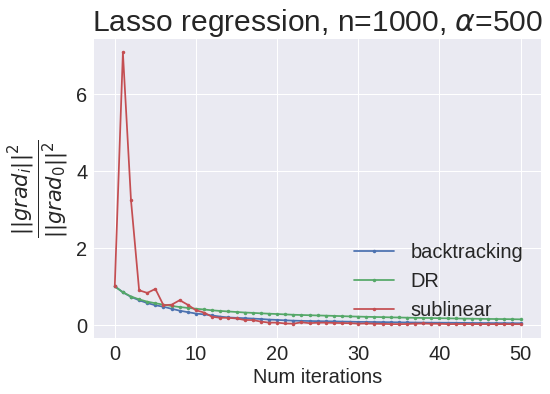

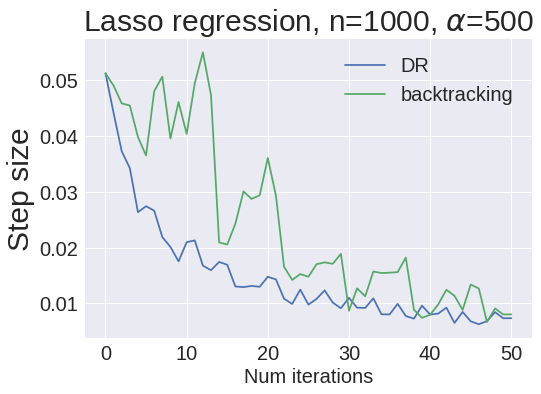

In [ ]:
LASSO_FW(1000, max_iter=50)

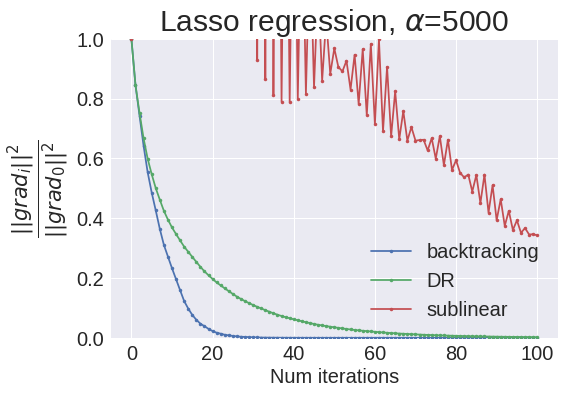